In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.efficientnet import EfficientNetB7

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Set seed
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


2025-06-28 09:39:03.513622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751103543.721972      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751103543.776199      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1


In [2]:
# === 1. Load Data ===
data_dir = '/kaggle/input/alzheimers/train'
filepaths, labels = [], []

for fold in os.listdir(data_dir):
    foldpath = os.path.join(data_dir, fold)
    for file in os.listdir(foldpath):
        filepaths.append(os.path.join(foldpath, file))
        labels.append(fold)

# DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
df = df[~df['filepaths'].str.contains('._')]
df['labels'] = df['labels'].str.strip()



Class Distribution:
 labels
NonDemented         3200
VeryMildDemented    2250
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


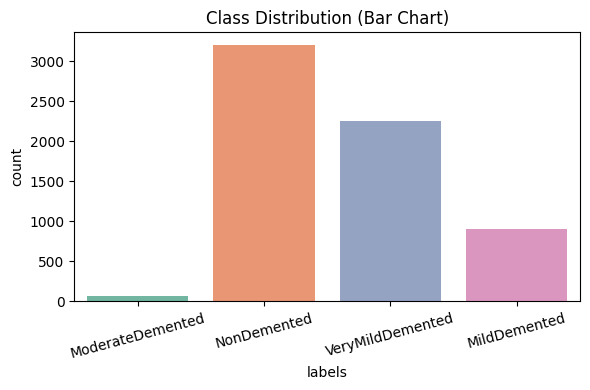

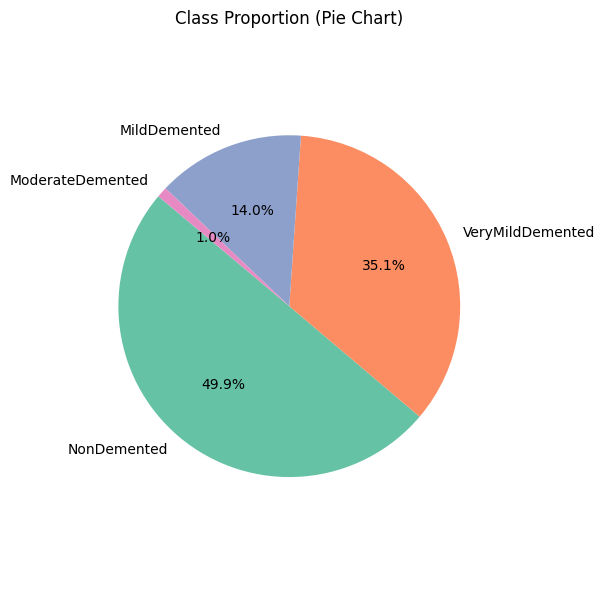

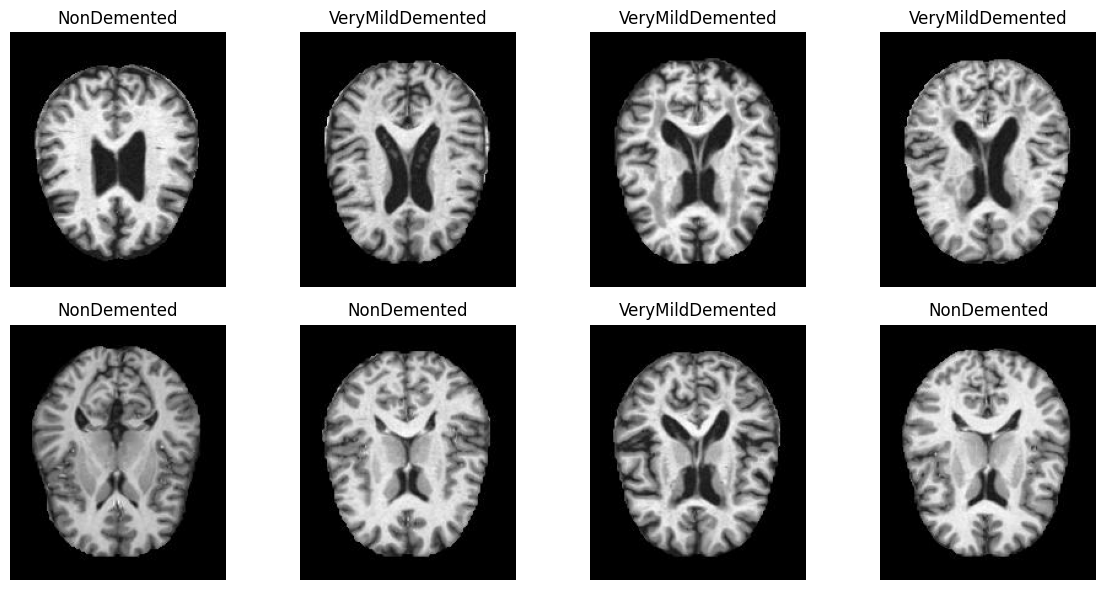

In [3]:
# === 2. Data Exploration ===
print("\nClass Distribution:\n", df['labels'].value_counts())

# Bar chart
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='labels', palette='Set2')
plt.title("Class Distribution (Bar Chart)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Pie chart
class_counts = df['labels'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title("Class Proportion (Pie Chart)")
plt.axis('equal')
plt.tight_layout()
plt.show()

# === 3. Visualize 8 Sample Images ===
sample_df = df.sample(n=8, random_state=seed).reset_index(drop=True)
plt.figure(figsize=(12, 6))
for i, row in sample_df.iterrows():
    img = cv2.imread(row['filepaths'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(row['labels'])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
# === 4. Data Split ===
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)

# === 5. Image Generators ===
batch_size = 32
img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

# Class index mapping
g_dict = train_gen.class_indices
classes = list(g_dict.keys())

Found 5128 validated image filenames belonging to 4 classes.
Found 769 validated image filenames belonging to 4 classes.
Found 513 validated image filenames belonging to 4 classes.


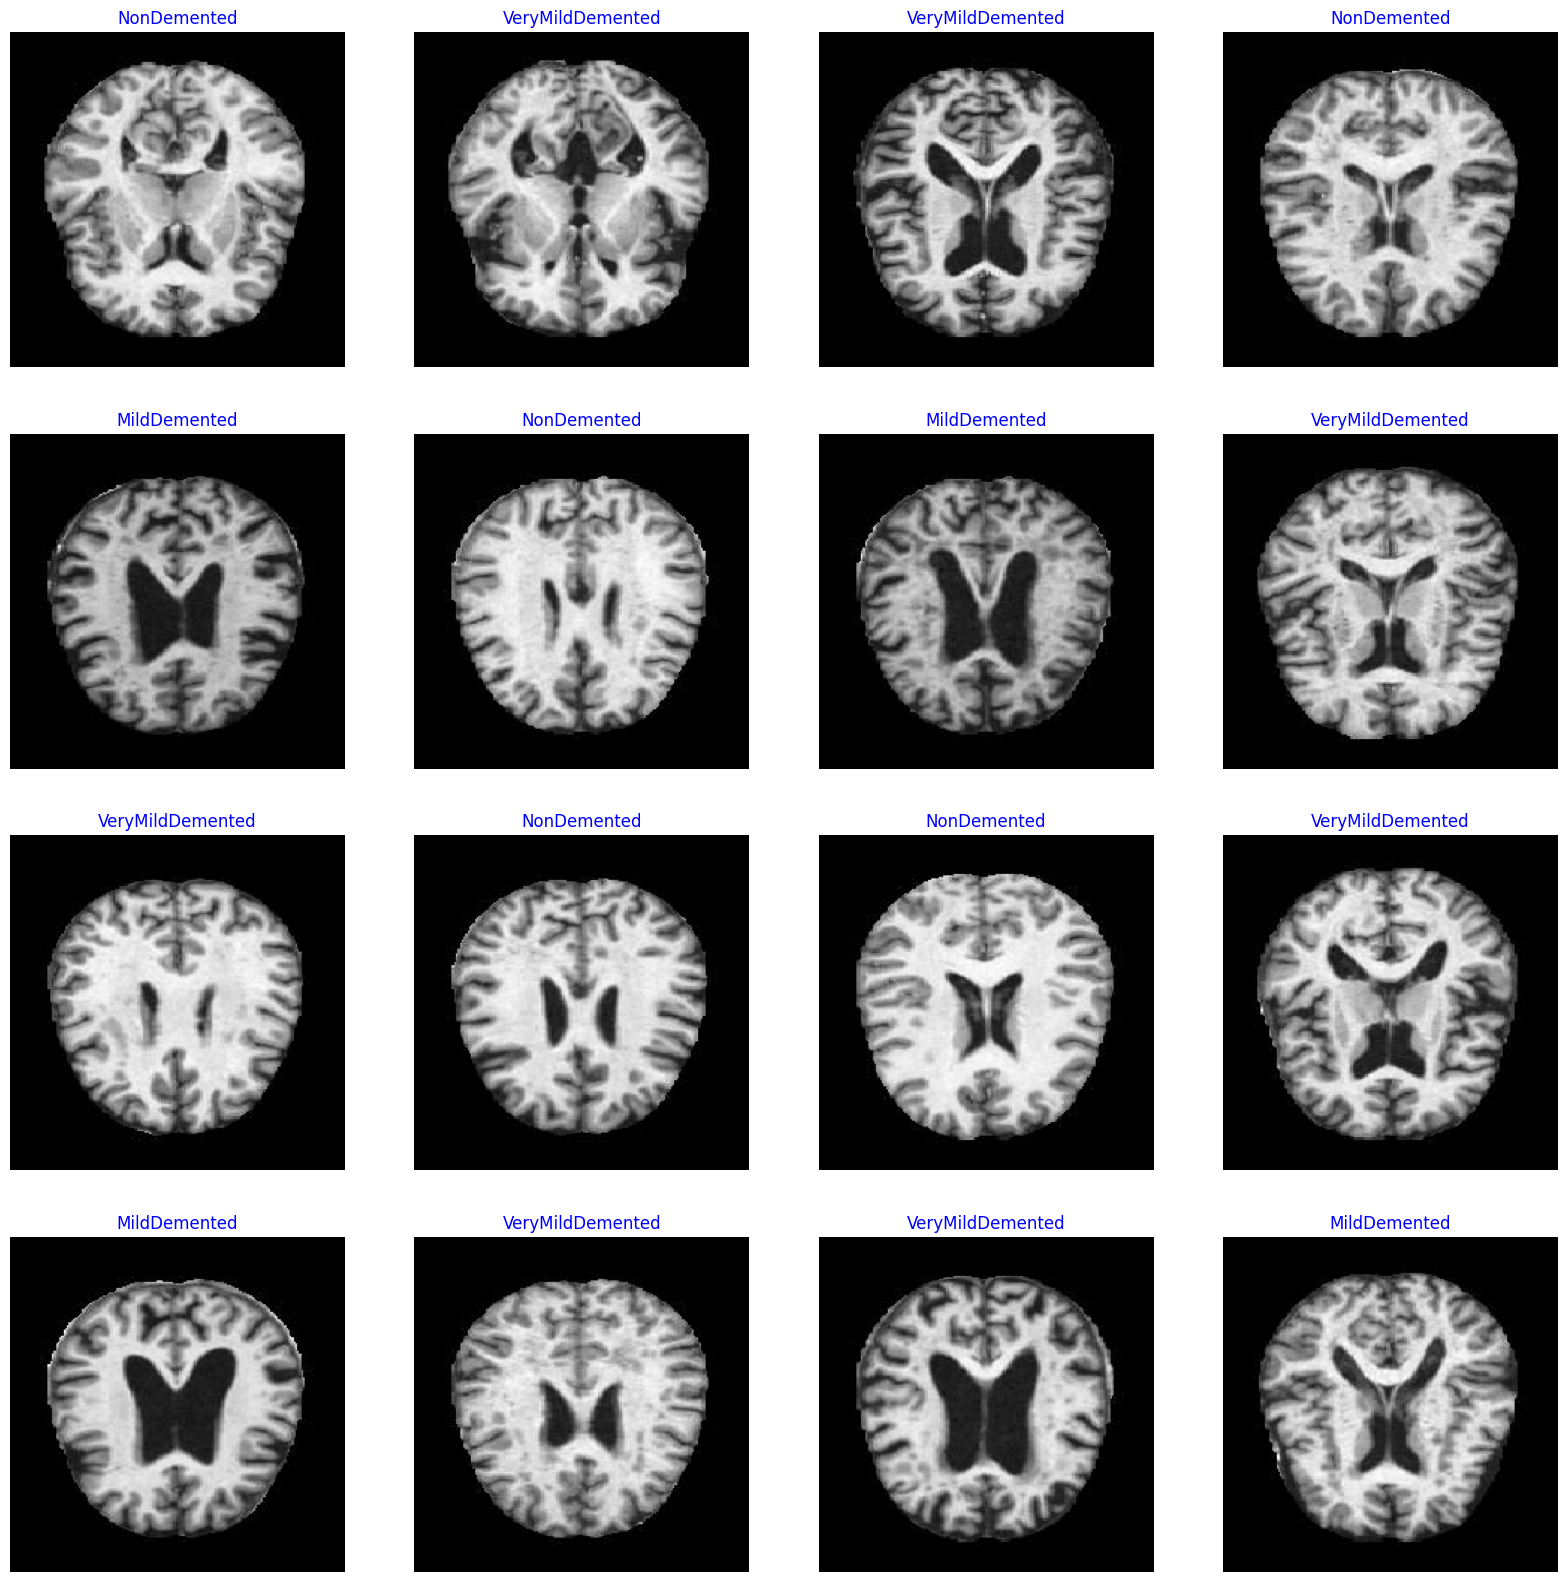

In [5]:
# === 6. Show First Batch of Training Images ===
images, labels = next(train_gen)
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    plt.title(classes[index], color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [6]:
# === 7. Model ===
EffB7 = EfficientNetB7(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
for layer in EffB7.layers:
    layer.trainable = False

x = Flatten()(EffB7.output)
out = Dense(4, activation='softmax')(x)
modelEffB7 = Model(inputs=EffB7.input, outputs=out)

# Compile
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
sgd = SGD(learning_rate=0.0001, momentum=0.9, decay=1e-4, nesterov=False)
modelEffB7.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


I0000 00:00:1751103572.710122      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Train
hist_EffB7 = modelEffB7.fit(train_gen, epochs=100, validation_data=valid_gen, verbose=1, callbacks=[callback])

# Evaluate
loss_EffB7, accuracy_EffB7 = modelEffB7.evaluate(test_gen)
print("\nTest Accuracy:", accuracy_EffB7)


Epoch 1/100


I0000 00:00:1751103629.690947      64 service.cc:148] XLA service 0x7b67f4004a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751103629.691540      64 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751103635.711212      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/161 ━━━━━━━━━━━━━━━━━━━━ 3:41:56 83s/step - accuracy: 0.5000 - loss: 1.3008

I0000 00:00:1751103663.450727      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 185s 634ms/step - accuracy: 0.5042 - loss: 1.1793 - val_accuracy: 0.3888 - val_loss: 1.4032
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.5794 - loss: 0.9490 - val_accuracy: 0.4226 - val_loss: 1.2744
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.5639 - loss: 1.1112 - val_accuracy: 0.6294 - val_loss: 0.8042
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.6598 - loss: 0.7962 - val_accuracy: 0.6554 - val_loss: 0.7609
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step - accuracy: 0.6673 - loss: 0.7677 - val_accuracy: 0.6489 - val_loss: 0.7854
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.6595 - loss: 0.8297 - val_accuracy: 0.6814 - val_loss: 0.7117
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step - accuracy: 0.6810 - loss: 0.7339 - val_accuracy: 0.6749 - val_loss: 0.7619
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.7146 - loss: 0.67

In [8]:
# === 8. Highlight Highest Validation Accuracy ===
best_val_acc = max(hist_EffB7.history['val_accuracy'])
print(f"\n Highest Validation Accuracy during training: {best_val_acc:.4f}")



 Highest Validation Accuracy during training: 0.8804


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


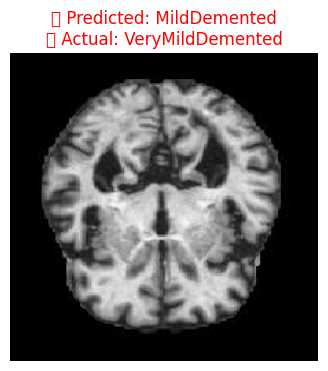

In [9]:
# === 9. Predict One Image ===
from tensorflow.keras.preprocessing import image
import random

sample_idx = random.randint(0, len(test_df) - 1)
sample_path = test_df.iloc[sample_idx]['filepaths']
true_label = test_df.iloc[sample_idx]['labels']

img = image.load_img(sample_path, target_size=img_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = modelEffB7.predict(img_array)
pred_label = classes[np.argmax(pred)]

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.title(f"🔹 Predicted: {pred_label}\n🔸 Actual: {true_label}", fontsize=12, 
          color='green' if pred_label == true_label else 'red')
plt.show()


In [10]:
# === 10. Traditional ML Models (LogReg, SVM, RF) ===
# Feature extraction for ML
def extract_features(generator):
    features, labels = [], []
    for batch_imgs, batch_labels in generator:
        feats = EffB7.predict(batch_imgs)
        feats = feats.reshape((feats.shape[0], -1))
        features.extend(feats)
        labels.extend(np.argmax(batch_labels, axis=1))
        if len(features) >= generator.n:
            break
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(train_gen)
X_test, y_test = extract_features(test_gen)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds, target_names=classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0